# **Model Trained with Balanced Data and Rating Scale (1-6)**

<ipython-input-3-95b2621d467f>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users['Age'].fillna(users['Age'].median(), inplace=True)
<ipython-input-3-95b2621d467f>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

Class distribution before downsampling:
Label
1    290217
0     93635
Name: count, dtype: int64
Class distribution after downsampling:
Label
0    93635
1    93635
Name: count, dtype: int64


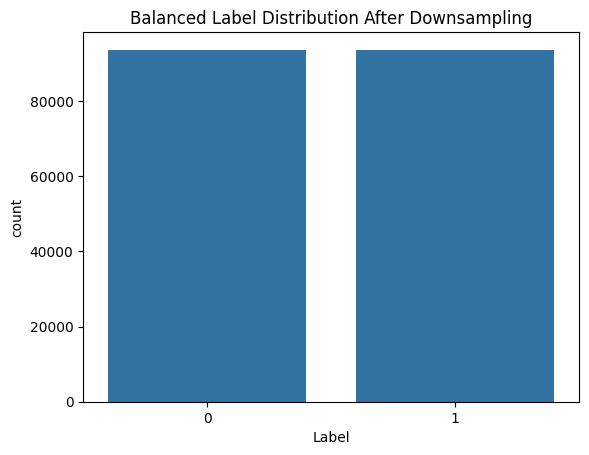

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# Load data
# If using Kaggle, ensure the Kaggle API is configured and download the dataset
# If using files, replace the path variables with file paths
def load_data():
    users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1')
    books = pd.read_csv('BX_Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')
    ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1')

    return users, books, ratings

users, books, ratings = load_data()

# Preprocessing Users Table
users['Age'].fillna(users['Age'].median(), inplace=True)
users['Location'] = users['Location'].str.split(',').str[-1].str.strip()  # Simplify to country level

# Preprocessing Books Table
books['Book-Title'].fillna('Unknown', inplace=True)
books['Book-Author'].fillna('Unknown', inplace=True)
books['Year-Of-Publication'].fillna(books['Year-Of-Publication'].median(), inplace=True)

# Filter ratings and merge
ratings = ratings[ratings['Book-Rating'] > 0]  # Remove implicit feedback
ratings = ratings.merge(users, on='User-ID').merge(books, on='ISBN')

# Indexing Book ID starting from 1
ratings['Book-ID'] = pd.factorize(ratings['ISBN'])[0] + 1

# Label encoding categorical variables
user_encoder = LabelEncoder()
ratings['User-ID'] = user_encoder.fit_transform(ratings['User-ID'])

location_encoder = LabelEncoder()
ratings['Location'] = location_encoder.fit_transform(ratings['Location'])

book_title_encoder = LabelEncoder()
ratings['Book-Title'] = book_title_encoder.fit_transform(ratings['Book-Title'])

book_author_encoder = LabelEncoder()
ratings['Book-Author'] = book_author_encoder.fit_transform(ratings['Book-Author'])

# Scale numerical features
scaler = MinMaxScaler()
ratings['Age'] = scaler.fit_transform(ratings[['Age']])
ratings['Year-Of-Publication'] = scaler.fit_transform(ratings[['Year-Of-Publication']])

# Label ratings
ratings['Label'] = (ratings['Book-Rating'] > 6).astype(int)



# Count the number of samples in each class
class_counts = ratings['Label'].value_counts()
print("Class distribution before downsampling:")
print(class_counts)

# Separate the majority and minority classes
majority_class = ratings[ratings['Label'] == 1]
minority_class = ratings[ratings['Label'] == 0]

# Downsample the majority class to match the minority class size
majority_downsampled = majority_class.sample(n=len(minority_class), random_state=42)

# Combine the downsampled majority class with the minority class
balanced_ratings = pd.concat([minority_class, majority_downsampled])

# Shuffle the combined dataset
balanced_ratings = balanced_ratings.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
print("Class distribution after downsampling:")
print(balanced_ratings['Label'].value_counts())

# Plot the balanced class distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Label', data=balanced_ratings)
plt.title('Balanced Label Distribution After Downsampling')
plt.show()

# Update the features and labels
X_balanced = balanced_ratings[['User-ID', 'Location', 'Age', 'Book-ID', 'Book-Title', 'Book-Author', 'Year-Of-Publication']]
y_balanced = balanced_ratings['Label']

# Train-test split on the balanced data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)


# Define the neural network
def build_model(num_users, num_locations, num_books, num_titles, num_authors, embedding_dim=100):
    # Inputs
    user_input = Input(shape=(1,), name='User-ID')
    location_input = Input(shape=(1,), name='Location')
    age_input = Input(shape=(1,), name='Age')
    book_input = Input(shape=(1,), name='Book-ID')
    title_input = Input(shape=(1,), name='Book-Title')
    author_input = Input(shape=(1,), name='Book-Author')
    year_input = Input(shape=(1,), name='Year-Of-Publication')

    # Embedding layers
    user_embedding = Embedding(num_users, embedding_dim, input_length=1)(user_input)
    location_embedding = Embedding(num_locations, embedding_dim, input_length=1)(location_input)
    book_embedding = Embedding(num_books, embedding_dim, input_length=1)(book_input)
    title_embedding = Embedding(num_titles, embedding_dim, input_length=1)(title_input)
    author_embedding = Embedding(num_authors, embedding_dim, input_length=1)(author_input)

    # Flatten embeddings
    user_flat = Flatten()(user_embedding)
    location_flat = Flatten()(location_embedding)
    book_flat = Flatten()(book_embedding)
    title_flat = Flatten()(title_embedding)
    author_flat = Flatten()(author_embedding)

    # Combine all features
    features = Concatenate()([user_flat, location_flat, age_input, book_flat, title_flat, author_flat, year_input])

    # Dense layers
    dense = Dense(256, activation='relu')(features)
    dense = Dropout(0.5)(dense)
    dense = Dense(128, activation='relu')(dense)
    dense = Dropout(0.5)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dropout(0.5)(dense)
    output = Dense(1, activation='sigmoid')(dense)

    # Model
    model = Model(inputs=[user_input, location_input, age_input, book_input, title_input, author_input, year_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build the model
num_users = ratings['User-ID'].nunique()+1
num_locations = ratings['Location'].nunique()+1
num_books = ratings['Book-ID'].nunique()+1
num_titles = ratings['Book-Title'].nunique()+1
num_authors = ratings['Book-Author'].nunique()+1

model = build_model(num_users, num_locations, num_books, num_titles, num_authors)




In [ ]:
ratings['Label'].count().sum()

383852

In [ ]:
# Ensure inputs are NumPy arrays with correct data types
X_train_prepared = [
    np.array(X_train['User-ID'], dtype=np.int32),
    np.array(X_train['Location'], dtype=np.int32),
    np.array(X_train['Age'], dtype=np.float32),
    np.array(X_train['Book-ID'], dtype=np.int32),
    np.array(X_train['Book-Title'], dtype=np.int32),
    np.array(X_train['Book-Author'], dtype=np.int32),
    np.array(X_train['Year-Of-Publication'], dtype=np.float32),
]

X_test_prepared = [
    np.array(X_test['User-ID'], dtype=np.int32),
    np.array(X_test['Location'], dtype=np.int32),
    np.array(X_test['Age'], dtype=np.float32),
    np.array(X_test['Book-ID'], dtype=np.int32),
    np.array(X_test['Book-Title'], dtype=np.int32),
    np.array(X_test['Book-Author'], dtype=np.int32),
    np.array(X_test['Year-Of-Publication'], dtype=np.float32),
]

# Labels as NumPy arrays
y_train_prepared = np.array(y_train, dtype=np.float32)
y_test_prepared = np.array(y_test, dtype=np.float32)

# Train the model
history = model.fit(
    X_train_prepared,
    y_train_prepared,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_prepared, y_test_prepared)

print(f"Test Accuracy: {accuracy:.2f}")


Epoch 1/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 497s 527ms/step - accuracy: 0.5721 - loss: 0.6623 - val_accuracy: 0.6611 - val_loss: 0.6026
Epoch 2/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 496s 529ms/step - accuracy: 0.8131 - loss: 0.4252 - val_accuracy: 0.6444 - val_loss: 0.6712
Epoch 3/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 505s 533ms/step - accuracy: 0.9013 - loss: 0.2351 - val_accuracy: 0.6436 - val_loss: 0.8363
Epoch 4/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 515s 547ms/step - accuracy: 0.9309 - loss: 0.1527 - val_accuracy: 0.6332 - val_loss: 1.0918
Epoch 5/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 565s 550ms/step - accuracy: 0.9508 - loss: 0.1092 - val_accuracy: 0.6228 - val_loss: 1.4071
Epoch 6/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 583s 572ms/step - accuracy: 0.9627 - loss: 0.0860 - val_accuracy: 0.6246 - val_loss: 1.6242
Epoch 7/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 546s 555ms/step - accuracy: 0.9732 - loss: 0.0629 - val_accuracy: 0.6188 - val_loss: 1.7383
Epoch 8/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 530s 565ms/step - accuracy: 0.9789 -

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
import numpy as np

# Make predictions
y_pred_probs = model.predict(X_test_prepared)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to binary (assuming binary classification)

# Precision
precision = precision_score(y_test_prepared, y_pred, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
print(f"Precision: {precision:.2f}")

# Recall
recall = recall_score(y_test_prepared, y_pred, average='binary')
print(f"Recall: {recall:.2f}")

# F1 Score
f1 = f1_score(y_test_prepared, y_pred, average='binary')
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_prepared, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Mean Average Precision (MAP)
average_precision = average_precision_score(y_test_prepared, y_pred_probs)
print(f"Mean Average Precision (MAP): {average_precision:.2f}")


1171/1171 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
Precision: 0.63
Recall: 0.58
F1 Score: 0.61
Confusion Matrix:
[[12411  6334]
 [ 7816 10893]]
Mean Average Precision (MAP): 0.66


# **Model Trained with UnBalanced Data with Rating Scale (1-7)**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# Load data
# If using Kaggle, ensure the Kaggle API is configured and download the dataset
# If using files, replace the path variables with file paths
def load_data():
    users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1')
    books = pd.read_csv('BX_Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')
    ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1')

    return users, books, ratings

users, books, ratings = load_data()

# Preprocessing Users Table
users['Age'].fillna(users['Age'].median(), inplace=True)
users['Location'] = users['Location'].str.split(',').str[-1].str.strip() # Simplify to country level

# Preprocessing Books Table
books['Book-Title'].fillna('Unknown', inplace=True)
books['Book-Author'].fillna('Unknown', inplace=True)
books['Year-Of-Publication'].fillna(books['Year-Of-Publication'].median(), inplace=True)

# Filter ratings and merge
ratings = ratings[ratings['Book-Rating'] > 0] # Remove implicit feedback
ratings = ratings.merge(users, on='User-ID').merge(books, on='ISBN')

# Indexing Book ID starting from 1
ratings['Book-ID'] = pd.factorize(ratings['ISBN'])[0] + 1

# Label encoding categorical variables
user_encoder = LabelEncoder()
ratings['User-ID'] = user_encoder.fit_transform(ratings['User-ID'])

location_encoder = LabelEncoder()
ratings['Location'] = location_encoder.fit_transform(ratings['Location'])

book_title_encoder = LabelEncoder()
ratings['Book-Title'] = book_title_encoder.fit_transform(ratings['Book-Title'])

book_author_encoder = LabelEncoder()
ratings['Book-Author'] = book_author_encoder.fit_transform(ratings['Book-Author'])

# Scale numerical features
scaler = MinMaxScaler()
ratings['Age'] = scaler.fit_transform(ratings[['Age']])
ratings['Year-Of-Publication'] = scaler.fit_transform(ratings[['Year-Of-Publication']])

# Label ratings
ratings['Label'] = (ratings['Book-Rating'] > 7).astype(int)





# Split features and labels
X = ratings[['User-ID', 'Location', 'Age', 'Book-ID', 'Book-Title', 'Book-Author', 'Year-Of-Publication']]
y = ratings['Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network
def build_model(num_users, num_locations, num_books, num_titles, num_authors, embedding_dim=50):
    # Inputs
    user_input = Input(shape=(1,), name='User-ID')
    location_input = Input(shape=(1,), name='Location')
    age_input = Input(shape=(1,), name='Age')
    book_input = Input(shape=(1,), name='Book-ID')
    title_input = Input(shape=(1,), name='Book-Title')
    author_input = Input(shape=(1,), name='Book-Author')
    year_input = Input(shape=(1,), name='Year-Of-Publication')

    # Embedding layers
    user_embedding = Embedding(num_users, embedding_dim, input_length=1)(user_input)
    location_embedding = Embedding(num_locations, embedding_dim, input_length=1)(location_input)
    book_embedding = Embedding(num_books, embedding_dim, input_length=1)(book_input)
    title_embedding = Embedding(num_titles, embedding_dim, input_length=1)(title_input)
    author_embedding = Embedding(num_authors, embedding_dim, input_length=1)(author_input)

    # Flatten embeddings
    user_flat = Flatten()(user_embedding)
    location_flat = Flatten()(location_embedding)
    book_flat = Flatten()(book_embedding)
    title_flat = Flatten()(title_embedding)
    author_flat = Flatten()(author_embedding)

    # Combine all features
    features = Concatenate()([user_flat, location_flat, age_input, book_flat, title_flat, author_flat, year_input])

    # Dense layers
    dense = Dense(128, activation='relu')(features)
    dense = Dropout(0.5)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dropout(0.5)(dense)
    output = Dense(1, activation='sigmoid')(dense)

    # Model
    model = Model(inputs=[user_input, location_input, age_input, book_input, title_input, author_input, year_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build the model
num_users = ratings['User-ID'].nunique()+1
num_locations = ratings['Location'].nunique()+1
num_books = ratings['Book-ID'].nunique()+1
num_titles = ratings['Book-Title'].nunique()+1
num_authors = ratings['Book-Author'].nunique()+1

model = build_model(num_users, num_locations, num_books, num_titles, num_authors)


<ipython-input-9-e10ffb6eee8d>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users['Age'].fillna(users['Age'].median(), inplace=True)
<ipython-input-9-e10ffb6eee8d>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

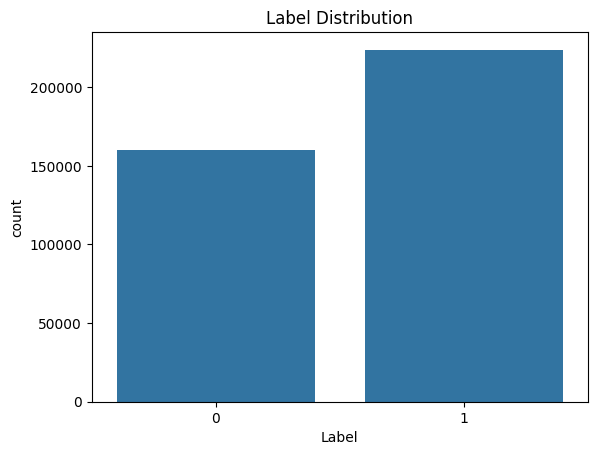

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='Label', data=ratings)
plt.title('Label Distribution')
plt.show()



In [ ]:
# Ensure inputs are NumPy arrays with correct data types
X_train_prepared = [
    np.array(X_train['User-ID'], dtype=np.int32),
    np.array(X_train['Location'], dtype=np.int32),
    np.array(X_train['Age'], dtype=np.float32),
    np.array(X_train['Book-ID'], dtype=np.int32),
    np.array(X_train['Book-Title'], dtype=np.int32),
    np.array(X_train['Book-Author'], dtype=np.int32),
    np.array(X_train['Year-Of-Publication'], dtype=np.float32),
]

X_test_prepared = [
    np.array(X_test['User-ID'], dtype=np.int32),
    np.array(X_test['Location'], dtype=np.int32),
    np.array(X_test['Age'], dtype=np.float32),
    np.array(X_test['Book-ID'], dtype=np.int32),
    np.array(X_test['Book-Title'], dtype=np.int32),
    np.array(X_test['Book-Author'], dtype=np.int32),
    np.array(X_test['Year-Of-Publication'], dtype=np.float32),
]

# Labels as NumPy arrays
y_train_prepared = np.array(y_train, dtype=np.float32)
y_test_prepared = np.array(y_test, dtype=np.float32)

# Train the model
history = model.fit(
    X_train_prepared,
    y_train_prepared,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_prepared, y_test_prepared)

print(f"Test Accuracy: {accuracy:.2f}")


Epoch 1/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 362s 187ms/step - accuracy: 0.6249 - loss: 0.6361 - val_accuracy: 0.6747 - val_loss: 0.5875
Epoch 2/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 389s 191ms/step - accuracy: 0.8014 - loss: 0.4415 - val_accuracy: 0.6573 - val_loss: 0.6439
Epoch 3/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 387s 194ms/step - accuracy: 0.8720 - loss: 0.2958 - val_accuracy: 0.6511 - val_loss: 0.7392
Epoch 4/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 381s 193ms/step - accuracy: 0.8973 - loss: 0.2249 - val_accuracy: 0.6489 - val_loss: 0.9020
Epoch 5/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 380s 192ms/step - accuracy: 0.9194 - loss: 0.1750 - val_accuracy: 0.6364 - val_loss: 1.0900
Epoch 6/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 372s 194ms/step - accuracy: 0.9346 - loss: 0.1430 - val_accuracy: 0.6381 - val_loss: 1.3333
Epoch 7/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 372s 189ms/step - accuracy: 0.9462 - loss: 0.1187 - val_accuracy: 0.6333 - val_loss: 1.5398
Epoch 8/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 362s 189ms/step - ac

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
import numpy as np

# Make predictions
y_pred_probs = model.predict(X_test_prepared)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to binary (assuming binary classification)

# Precision
precision = precision_score(y_test_prepared, y_pred, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
print(f"Precision: {precision:.2f}")

# Recall
recall = recall_score(y_test_prepared, y_pred, average='binary')
print(f"Recall: {recall:.2f}")

# F1 Score
f1 = f1_score(y_test_prepared, y_pred, average='binary')
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_prepared, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Mean Average Precision (MAP)
average_precision = average_precision_score(y_test_prepared, y_pred_probs)
print(f"Mean Average Precision (MAP): {average_precision:.2f}")


2400/2400 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Precision: 0.69
Recall: 0.66
F1 Score: 0.67
Confusion Matrix:
[[18665 13462]
 [15271 29373]]
Mean Average Precision (MAP): 0.72
